In [2]:
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')  # ignore DeprecationWarnings from tensorflow

import matplotlib.pyplot as plt
%matplotlib inline

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter

#from multiclass_classification import plot_posterior_predictions, colors

np.random.seed(0)  # reproducibility

In [3]:
# Number of functions and number of data points
C = 3
N = 100

# RBF kernel lengthscale
lengthscale = 0.1

# Jitter
jitter_eye = np.eye(N) * 1e-6

# Input
X = np.random.rand(N, 1)

In [4]:
# SquaredExponential kernel matrix
kernel_se = gpflow.kernels.SquaredExponential(lengthscale=lengthscale)
K = kernel_se(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T

# Hard max observation
Y = np.argmax(f, 1).reshape(-1,).astype(int)

# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

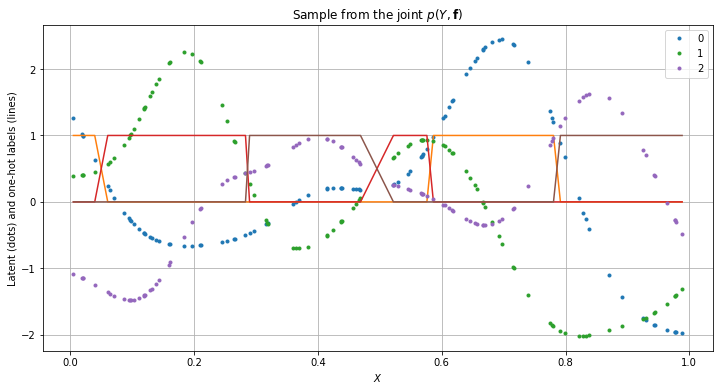

In [5]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):
    plt.plot(X[order], f[order, c], '.', label=str(c))
    plt.plot(X[order], Y_hot[order, c], '-')


plt.legend()
plt.xlabel('$X$')
plt.ylabel('Latent (dots) and one-hot labels (lines)')
plt.title('Sample from the joint $p(Y, \mathbf{f})$')
plt.grid()
plt.show()

In [7]:
# sum kernel: Matern32 + White
kernel = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(3, invlink=invlink)  # Multiclass likelihood
Z = X[::5].copy()  # inducing inputs

m = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z, num_latent=C, whiten=True, q_diag=True)

# Only train the variational parameters
set_trainable(m.kernel.kernels[1].variance, False)
set_trainable(m.inducing_variable, False)
print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,False,(),float64,0.009999999776482648
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
SVGP.inducing_variable.Z,Parameter,,False,"(20, 1)",float64,[[0.5488135...
SVGP.q_mu,Parameter,,True,"(20, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,True,"(20, 3)",float64,"[[1., 1., 1...."


In [9]:
opt = gpflow.optimizers.Scipy()

In [ ]:
opt = gpflow.optimizers.Scipy()

obj= - m.log_marginal_likelihood(data)

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=ci_niter(1000)))
print_summary(m, fmt='notebook')